In [1]:
import sys,os
import healpy as h
sys.path.append("../")
%pylab notebook
from modules import analysis
from modules import get_data as gd
import collections
import pandas as pd
pd.set_option('display.max_colwidth', 400)

def ensure_dir(file_path):
	directory = os.path.dirname(file_path)
	if not os.path.exists(directory):
		os.makedirs(directory)
        
from scipy.interpolate import interp1d
from scipy.integrate import quad
pd.set_option('display.max_colwidth', -1)
from scipy.io.idl import readsav


Populating the interactive namespace from numpy and matplotlib


In [2]:
maskname="mask46"
ion()
if maskname=="mask62":
    filename="../../dataout/masks/apodized_masks2m2m_v2.sav"
    vv=readsav(filename) ; print vv.viewkeys()
    mask=vv.apomask1m
elif maskname=="mask46":
    filename="../../dataout/masks/apodized_masks_v2.sav"
    vv=readsav(filename) ; print vv.viewkeys()
    mask=vv.apomask1m
elif maskname=="bicep":
    filename="../../dataout/masks/bicep2_mask_ns512.sav"
    vv=readsav(filename) ; print vv.viewkeys()
    mask=vv.bicep2mask
    
# mask[:]=1.

dict_keys(['apomask2m1', 'apomask1m'])


# Paths

In [3]:
# result_path="../../results/final/" + maskname + "/PICO_rvar0/" ; instrument="PICO"
# result_path="../../results/final/" + maskname + "/PICO_COVMASK/" ; instrument="PICO"
# result_path="../../results/final/" + maskname + "/PICO_LITE/" ; instrument="PICO_LITE"
# result_path="../../results/final/" + maskname + "/PICO_MHD_rvar0/" ; instrument="PICO"
# result_path="../../results/final/" + maskname + "/LITEBIRD/" ; instrument="LITEBIRD"

#Results on in-house simulations
# result_path="../../results/final/" + maskname + "/PICO_AR/" ; instrument="PICO"
# result_path="../../results/final/" + maskname + "/PICO_CP_rvar0/" ; instrument="PICO"
# result_path="../../results/final/" + maskname + "/LITEBIRD_AR/" ; instrument="LITEBIRD"
result_path="../../results/final/" + maskname + "/LITEBIRD_AR_NEW_rvar0/" ; instrument="LITEBIRD"


ensure_dir(result_path)
tex_path=result_path + "/tex_table/"
ensure_dir(tex_path)
fig_path=result_path + "/figures/"
ensure_dir(fig_path)

ioff()
h.mollview(mask,title=r"$f_{\rm sky}$ = " + str(round(sum(mask)/size(mask),4)))
filename = fig_path + "mask.pdf"
savefig(filename,bbox_inches="tight")

color={}
color[0.0]="tab:blue"
color[0.4]="tab:green"
color[1.]="tab:red"

# Analysis

In [4]:
rf=analysis.setup_r_forecasts(instrument=instrument,only_return_dict=False,verbose=False)
rf.setup_master(lmin=2,lmax=450,dell=16,fwhm=40.,mask=mask)
rf.run_spectral_analysis()
rf.tabulate_rlike(Alens_vals=[0.0,0.4,1.],rprop=[1e-5,1e-1,4000],compute_map=False,rvar=0.)
rf.tabulate_rstat()

In [5]:
rf.dd["outdatapath"]

'/Users/adityarotti/Documents/Work/Projects/bmode_moments_analysis//dataout/litebird_double_ar_new/'

# Make tables

In [8]:
data_dict=collections.OrderedDict()
data_dict["Case"]=[]
data_dict["Moments"]=[]
data_dict["Parameters"]=[]
for idx,adr in enumerate(rf.adr_list):
    data_dict["Moments"]=data_dict["Moments"] + [rf.dd["lbl"][adr][10:]]
    data_dict["Parameters"]=data_dict["Parameters"] + [rf.dd["npar"][adr]]
    if adr=="cMILC00":
        adr="NILC"
    data_dict["Case"]=data_dict["Case"] + [adr]
df_datadef=pd.DataFrame(data_dict)

# Do not uncomment this line it gives bugs in the Latex file.
# df_datadef=df_datadef.set_index(["Case","Moments"],inplace=False)

filename=tex_path + "/data_definition.tex"
df_datadef.to_latex(filename,columns=["Case","Moments","Parameters"],column_format="cll",escape=False,index=False)

In [9]:
df_datadef

,Case,Moments,Parameters
0,NILC,$f_{\rm CMB}$,1
1,cMILC01,$f_{\rm CMB}$ ; $f_{\rm sync}$,2
2,cMILC02,$f_{\rm CMB}$ ; $f_{\rm dust}$,2
3,cMILC03,$f_{\rm CMB}$ ; $f_{\rm sync}$ ; $f_{\rm dust}$,3
4,cMILC04,$f_{\rm CMB}$ ; $f_{\rm dust}$ ; $\frac{d f_{\rm dust}}{d \beta}$,3
5,cMILC05,$f_{\rm CMB}$ ; $f_{\rm sync}$ ; $f_{\rm dust}$ ; $\frac{d f_{\rm sync}}{d \beta}$,4
6,cMILC06,$f_{\rm CMB}$ ; $f_{\rm sync}$ ; $f_{\rm dust}$ ; $\frac{d f_{\rm dust}}{d \beta}$,4
7,cMILC07,$f_{\rm CMB}$ ; $f_{\rm sync}$ ; $f_{\rm dust}$ ; $\frac{d f_{\rm sync}}{d \beta}$ ; $\frac{d f_{\rm dust}}{d \beta}$,5
8,cMILC08,$f_{\rm CMB}$ ; $f_{\rm sync}$ ; $f_{\rm dust}$ ; $\frac{d f_{\rm sync}}{d \beta}$ ; $\frac{d f_{\rm dust}}{d \beta}$ ; $\frac{d f_{\rm dust}}{d T}$,6


In [10]:
table_stat=collections.OrderedDict()
# Ordering here is important. Same ordering in table and also for column names
table_stat["Case"]=[]
table_stat["Alens"]=[]
table_stat["rbias"]=[]
table_stat["rerr"]=[]
table_stat["ul"]=[]
table_stat["snr"]=[]

for adr in rf.adr_list:
    for Alens in rf.Alens_vals:
        if adr=="cMILC00":
            table_stat["Case"]=table_stat["Case"] + list(["NILC"])
        else:
            table_stat["Case"]=table_stat["Case"] + list([adr])
        table_stat["Alens"]=table_stat["Alens"] + list([Alens])
        table_stat["rbias"]=table_stat["rbias"] + list([rf.rstat[adr][Alens]["mp"]])
        table_stat["rerr"]=table_stat["rerr"] + list([rf.rstat[adr][Alens]["sigma"]])
        table_stat["snr"]=table_stat["snr"] + list([rf.rstat[adr][Alens]["snr"]])
        table_stat["ul"]=table_stat["ul"] + list(np.float64([rf.rstat[adr][Alens]["ul"]]))
        
df_stat=pd.DataFrame(table_stat)
# df_stat.set_index(["Case","Alens","rbias","rerrl","rerrh","ul"],inplace=True)
df_stat.set_index(["Case","Alens"],inplace=True)
df_stat.columns=[r"$r_{\rm bias}$ ",r"$\sigma_r$",r"$r_{95}$","SNR"]
filename=tex_path + "r_statistics.tex"
df_stat.to_latex(filename,longtable=True,column_format="cccccc",escape=False,float_format="%.5f")#'%.4f')

In [11]:
df_stat

$r_{\rm bias}$   $\sigma_r$  $r_{95}$       SNR
Case    Alens                                                 
NILC    0.0    0.003196         0.000388   NaN        8.240440
        0.4    0.002733         0.000649   NaN        4.211454
        1.0    0.002464         0.000975   NaN        2.527078
cMILC01 0.0    0.002592         0.000515   NaN        5.035927
        0.4    0.002386         0.000739   NaN        3.229601
        1.0    0.002268         0.001045   NaN        2.170455
cMILC02 0.0    0.003052         0.000402   NaN        7.595277
        0.4    0.002515         0.000664   NaN        3.787306
        1.0    0.002161         0.000993   NaN        2.176199
cMILC03 0.0    0.002337         0.000539   NaN        4.332178
        0.4    0.002063         0.000766   NaN        2.692663
        1.0    0.001860         0.001074    0.004065  1.732848
cMILC04 0.0    0.002464         0.000909   NaN        2.709170
        0.4    0.002321         0.001123   NaN        2.066212
        1.0    0.002201         0.001417    0.005110  1.552818
cMILC05 0.0    0.005698         0.001912   NaN        2.980282
        0.4    0.005454         0.002123   NaN        2.568263
        1.0    0.005137         0.002433   NaN        2.111108
cMILC06 0.0    0.000691         0.001160    0.003073  0.595615
        0.4    0.000732         0.001348    0.003498  0.543094
        1.0    0.000799         0.001616    0.004117  0.494277
cMILC07 0.0    0.001215         0.003806    0.009029  0.319157
        0.4    0.001220         0.003984    0.009401  0.306301
        1.0    0.001226         0.004249    0.009949  0.288572
cMILC08 0.0    0.000335         0.015926    0.033031  0.021051
        0.4    0.000336         0.016007    0.033198  0.020993
        1.0    0.000336         0.016129    0.033449  0.020834

# Make figures

## Likelihood evolution movie

In [12]:
ioff()
jpeg_path=fig_path + "/jpeg/" ; ensure_dir(jpeg_path)
for adr in rf.adr_list:
    filename=jpeg_path + "ps_and_bbposterir_" + adr + ".jpeg"
    filename_pdf=fig_path + "ps_and_bbposterir_" + adr + ".pdf"
    fig, ax = subplots(nrows=1, ncols=2, figsize=(16, 5))
#   fig, ax = subplots(nrows=1, ncols=2, figsize=(10, 3))
    ax[0].plot(rf.lbin,rf.clbin["lens"],"k*-",ms=8,lw=3,label=r"Theory $r \in [10^{-2},10^{-3}]$",alpha=0.6)
    ax[0].fill_between(rf.lbin,rf.clbin["bb"]*1e-2,rf.clbin["bb"]*1e-3,color="k",alpha=0.2)
    ax[0].plot(rf.lbin,rf.clbin["cmb"],"m.-",lw=3,label="True CMB")
    ax[0].plot(rf.lbin,rf.clbin["obs"][adr],"g--",lw=3,label="Observations")
    ax[0].plot(rf.lbin,rf.clbin["frg"][adr],"r-",lw=2,label="Residuals")
    var=((Alens*rf.clbin["cmb"])**2. + rf.clbin["noise"][adr]**2. + rf.clbin["frg"][adr]**2.)
    var=var*(2./((2.*rf.lbin+1)*rf.dell*rf.fsky))
    ax[0].plot(rf.lbin,np.sqrt(var),"bo-",alpha=0.5,lw=3,label=r"Total Noise $[A_{\rm lens}=$" + str(Alens) + "]")
    ax[0].plot(rf.lbin,rf.clbin["noise"][adr]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky))),'--',c="brown",lw=3,label="Instrument Noise")
    ax[0].legend(loc="upper left",ncol=2,title=rf.dd['simname'] + " [Lmax=" + str(rf.lmax) + "]",fontsize=8)
    ax[0].set_ylim(1e-6,1e1)
    ax[0].set_xlabel(r"multipole, $\ell$",fontsize=10)
    ax[0].set_ylabel(r"$\ell(\ell+1)C_{\ell}/(2\pi)$" + "  $\mu K^2$",fontsize=10)
    ax[0].grid(which="both",linestyle="--",alpha=0.5)
    ax[0].semilogy()
    ax[0].semilogx()
    for Alensp in rf.Alens_vals:
        ax[1].plot(rf.rvalues,rf.rlike_dict[adr][Alensp],lw=2,label=r"$A_{\rm lens}=" + str(Alensp) + "$",c=color[Alensp])
        ax[1].axvline(rf.rstat[adr][Alensp]["mp"],linestyle="-",alpha=0.8,c=color[Alensp])
        ax[1].axvline(rf.rstat[adr][Alensp]["mp"] - rf.rstat[adr][Alensp]["sigma"],linestyle="--",alpha=0.8,c=color[Alensp])
        ax[1].axvline(rf.rstat[adr][Alensp]["mp"] + rf.rstat[adr][Alensp]["sigma"],linestyle="--",alpha=0.8,c=color[Alensp])
    ax[1].set_xlabel("Tensor to scalar ratio (r)",fontsize=10)
    ax[1].set_ylabel(r"$e^{-\chi^2/2}$",fontsize=10)
    ax[1].legend(loc="upper right")
    ax[1].set_ylim(0,1.1)
    ax[1].grid(which="both",linestyle="--",alpha=0.4)
#     ax[1].semilogx()
    ax[1].set_xlim(1e-4,5e-3)
    ax[1].axvline(1e-3,color="k",linestyle="--",alpha=0.3)
    fig.suptitle(rf.dd["lbl"][adr])
    savefig(filename,bbox_inches="tight")
    ax[1].set_xlim(rf.rprop[0],rf.rprop[1])
    ax[1].semilogx()
    savefig(filename_pdf,bbox_inches="tight")
    
cwd=os.getcwd()
os.chdir(jpeg_path)
cmd = "convert -delay 200 -loop 0 *.jpeg ../" +  rf.dd['simname']
cmd = cmd + "_bbstat_evolve_moments_lmax" + str(rf.lmax) + "_dl" + str(rf.dell) + ".gif"
os.system(cmd)
cmd="rm *.jpeg" ; os.system(cmd)
os.chdir(cwd)

## PS summary

In [14]:
if "LITEBIRD" in rf.instrument:
    fig, ax = subplots(nrows=1, ncols=2, figsize=(16, 5),sharey=True)
    # fig, ax = subplots(nrows=1, ncols=2, figsize=(4, 3))
    ax[0].plot(rf.lbin,rf.clbin["frg"]["cMILC00"],"r-",lw=2,label="NILC Frg. residuals")
    ax[0].plot(rf.lbin,rf.clbin["frg"]["cMILC03"],"g-",lw=2,label="cMILC03 Frg. residuals")
    ax[0].plot(rf.lbin,rf.clbin["frg"]["cMILC06"],"m-",lw=2,label="cMILC06 Frg. residuals")
    ax[0].plot(rf.lbin,rf.clbin["frg"]["cMILC08"],"b-",lw=2,label="cMILC08 Frg. residuals")
#     ax[0].plot(rf.lbin,rf.clbin["frg"]["cMILC12"],"c-",lw=2,label="cMILC12 Frg. residuals")
    ax[0].plot(rf.lbin,rf.clbin["lens"],"k-.",ms=8,lw=3,alpha=0.8,label="Lensing $C_{\ell}^{BB}$")
    ax[0].fill_between(rf.lbin,rf.clbin["bb"]*1e-2,rf.clbin["bb"]*1e-3,color="k",alpha=0.2,label=r"Theory $r \in [10^{-2},10^{-3}]$")
    ax[0].set_xlabel(r"multipole, $\ell$",fontsize=15)
    ax[0].set_ylabel(r"$\ell(\ell+1)C_{\ell}/(2\pi)$" + "  $\mu K^2$",fontsize=15)
    ax[0].grid(which="both",linestyle="--",alpha=0.5)
    ax[0].loglog()
    ax[0].legend(loc="upper left",title=rf.instrument,
                fancybox=True,facecolor="wheat",framealpha=0.6,edgecolor="black")
    ax[0].set_ylim(5e-7,1e-1)

    ax[1].plot(rf.lbin,rf.clbin["noise"]["cMILC00"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky))),"r-",lw=2,label="NILC noise error")
    ax[1].plot(rf.lbin,rf.clbin["noise"]["cMILC03"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky))),"g-",lw=2,label="cMILC03 noise error")
    ax[1].plot(rf.lbin,rf.clbin["noise"]["cMILC06"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky))),"m-",lw=2,label="cMILC06 noise error")
    ax[1].plot(rf.lbin,rf.clbin["noise"]["cMILC08"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky))),"b-",lw=2,label="cMILC08 noise error")
#     ax[1].plot(rf.lbin,rf.clbin["noise"]["cMILC12"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky))),"c-",lw=2,label="cMILC12 noise error")
    lens_err_h=1.*rf.clbin["lens"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky)))
    lens_err_l=0.1*rf.clbin["lens"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky)))
    ax[1].fill_between(rf.lbin,lens_err_l,lens_err_h,color="tab:olive",label=r"Lensing noise $A_{\rm L}\in[0.1,1.]$ ",alpha=0.6)
    ax[1].fill_between(rf.lbin,rf.clbin["bb"]*1e-2,rf.clbin["bb"]*1e-3,color="k",alpha=0.2)#,label=r"Theory $r \in [10^{-2},10^{-3}]$")
    ax[1].plot(rf.lbin,rf.clbin["lens"],"k-.",ms=8,lw=3,alpha=0.8)#,label="Lensing $C_{\ell}^{BB}$")
    ax[1].set_xlabel(r"multipole, $\ell$",fontsize=15)
#     ax[1].set_ylabel(r"$\ell(\ell+1)C_{\ell}/(2\pi)$" + "  $\mu K^2$",fontsize=15)
    ax[1].grid(which="both",linestyle="--",alpha=0.5)
    ax[1].loglog()
    ax[1].legend(loc="upper left",title=rf.instrument,
                 fancybox=True,facecolor="wheat",framealpha=0.6,edgecolor="black")
    ax[1].set_ylim(5e-7,1e-1)
    subplots_adjust(wspace=0.05, hspace=0)
    filename_pdf=fig_path + rf.instrument + "_ps_summary.pdf"
    savefig(filename_pdf,bbox_inches="tight")
    filename_pdf=fig_path + rf.instrument + "_ps_summary.jpeg"
    savefig(filename_pdf,bbox_inches="tight")
elif "PICO" in rf.instrument:
    fig, ax = subplots(nrows=1, ncols=2, figsize=(16, 5),sharey=True)
    # fig, ax = subplots(nrows=1, ncols=2, figsize=(4, 3))
    ax[0].plot(rf.lbin,rf.clbin["frg"]["cMILC00"],"r-",lw=2,label="NILC Frg. residuals")
    ax[0].plot(rf.lbin,rf.clbin["frg"]["cMILC03"],"g-",lw=2,label="cMILC03 Frg. residuals")
    ax[0].plot(rf.lbin,rf.clbin["frg"]["cMILC08"],"m-",lw=2,label="cMILC08 Frg. residuals")
    ax[0].plot(rf.lbin,rf.clbin["frg"]["cMILC10"],"b-",lw=2,label="cMILC10 Frg. residuals")
    ax[0].plot(rf.lbin,rf.clbin["frg"]["cMILC12"],c="tab:orange",lw=2,label="cMILC12 Frg. residuals")
    ax[0].plot(rf.lbin,rf.clbin["lens"],"k-.",ms=8,lw=3,alpha=0.8,label="Lensing $C_{\ell}^{BB}$")
    ax[0].fill_between(rf.lbin,rf.clbin["bb"]*1e-2,rf.clbin["bb"]*1e-3,color="k",alpha=0.2,label=r"Theory $r \in [10^{-2},10^{-3}]$")
    ax[0].set_xlabel(r"multipole, $\ell$",fontsize=15)
    ax[0].set_ylabel(r"$\ell(\ell+1)C_{\ell}/(2\pi)$" + "  $\mu K^2$",fontsize=15)
    ax[0].grid(which="both",linestyle="--",alpha=0.5)
    ax[0].loglog()
    ax[0].legend(loc="upper left",title=rf.instrument,
                fancybox=True,facecolor="wheat",framealpha=0.6,edgecolor="black")
    ax[0].set_ylim(1e-7,1e-1)

    ax[1].plot(rf.lbin,rf.clbin["noise"]["cMILC00"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky))),"r-",lw=2,label="NILC noise error")
    ax[1].plot(rf.lbin,rf.clbin["noise"]["cMILC03"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky))),"g-",lw=2,label="cMILC03 noise error")
    ax[1].plot(rf.lbin,rf.clbin["noise"]["cMILC08"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky))),"m-",lw=2,label="cMILC08 noise error")
    ax[1].plot(rf.lbin,rf.clbin["noise"]["cMILC10"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky))),"b-",lw=2,label="cMILC10 noise error")
    ax[1].plot(rf.lbin,rf.clbin["noise"]["cMILC12"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky))),c="tab:orange",lw=2,label="cMILC12 noise error")
    lens_err_h=1.*rf.clbin["lens"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky)))
    lens_err_l=0.1*rf.clbin["lens"]*sqrt((2./((2.*rf.lbin+1)*rf.dell*rf.fsky)))
    ax[1].fill_between(rf.lbin,lens_err_l,lens_err_h,color="tab:olive",label=r"Lensing noise $A_{\rm L}\in[0.1,1.]$ ",alpha=0.6)
    ax[1].fill_between(rf.lbin,rf.clbin["bb"]*1e-2,rf.clbin["bb"]*1e-3,color="k",alpha=0.2)#,label=r"Theory $r \in [10^{-2},10^{-3}]$")
    ax[1].plot(rf.lbin,rf.clbin["lens"],"k-.",ms=8,lw=3,alpha=0.8)#,label="Lensing $C_{\ell}^{BB}$")
    ax[1].set_xlabel(r"multipole, $\ell$",fontsize=15)
#     ax[1].set_ylabel(r"$\ell(\ell+1)C_{\ell}/(2\pi)$" + "  $\mu K^2$",fontsize=15)
    ax[1].grid(which="both",linestyle="--",alpha=0.5)
    ax[1].loglog()
    ax[1].legend(loc="upper left",title=rf.instrument,
                fancybox=True,facecolor="wheat",framealpha=0.6,edgecolor="black")
    ax[1].set_ylim(1e-7,1e-1)
    subplots_adjust(wspace=0.05, hspace=0)
    filename_pdf=fig_path + rf.instrument + "_ps_summary.pdf"
    savefig(filename_pdf,bbox_inches="tight")
    filename_pdf=fig_path + rf.instrument + "_ps_summary.jpeg"
    savefig(filename_pdf,bbox_inches="tight")

## Multipole by Multipole likelihood

In [9]:
ioff()
locx=linspace(0,len(rf.lbin)-1,5) ; tickx=linspace(min(rf.lbin),max(rf.lbin),5)
locy=linspace(0,len(rf.rvalues)-1,3) ; ticky=logspace(log10(rf.rprop[0]),log10(rf.rprop[1]),3)

jpeg_path=fig_path + "/jpeg/" ; ensure_dir(jpeg_path)

for adr in rf.adr_list:
    filename=jpeg_path + "ellbyell_bbposterir_" + adr + ".jpeg"
    fig, ax = subplots(nrows=2, ncols=2, figsize=(13, 8))

    i=0 ; j=0 ; Alens=0.0
    img0=ax[i,j].imshow(rf.rlike_map_dict[adr][Alens],aspect='auto',origin="lower",vmin=0,vmax=1)
    ax[i,j].set_xticks(locx) ; ax[i,j].set_xticklabels(tickx)
    ax[i,j].set_yticks(locy) ; ax[i,j].set_yticklabels(ticky)
    ax[i,j].set_title(r"$A_{\rm lens}=$" + str(Alens))
    # fig.colorbar(img0,ax=ax[i,j])
    ax[i,j].set_aspect('auto')

    i=0 ; j=1 ; Alens=0.3
    img1=ax[i,j].imshow(rf.rlike_map_dict[adr][Alens],aspect='auto',origin="lower",vmin=0,vmax=1)
    ax[i,j].set_xticks(locx) ; ax[i,j].set_xticklabels(tickx)
    ax[i,j].set_yticks(locy) ; ax[i,j].set_yticklabels(ticky)
    ax[i,j].set_title(r"$A_{\rm lens}=$" + str(Alens))
    # fig.colorbar(img1,ax=ax[i,j])
    ax[i,j].set_aspect('auto')

    i=1 ; j=0 ; Alens=0.6
    img2=ax[i,j].imshow(rf.rlike_map_dict[adr][Alens],aspect='auto',origin="lower",vmin=0,vmax=1)
    ax[i,j].set_xticks(locx) ; ax[i,j].set_xticklabels(tickx)
    ax[i,j].set_yticks(locy) ; ax[i,j].set_yticklabels(ticky)
    ax[i,j].set_title(r"$A_{\rm lens}=$" + str(Alens))
    # fig.colorbar(img2,ax=ax[i,j])
    ax[i,j].set_aspect('auto')

    i=1 ; j=1 ; Alens=0.9
    img3=ax[i,j].imshow(rf.rlike_map_dict[adr][Alens],aspect='auto',origin="lower",vmin=0,vmax=1)
    ax[i,j].set_xticks(locx) ; ax[i,j].set_xticklabels(tickx)
    ax[i,j].set_yticks(locy) ; ax[i,j].set_yticklabels(ticky)
    ax[i,j].set_title(r"$A_{\rm lens}=$" + str(Alens))
    # fig.colorbar(img3,ax=ax[i,j])
    ax[i,j].set_aspect('auto')

    fig.colorbar(img0, ax=ax.ravel().tolist(), shrink=0.6)

    fig.suptitle(rf.dd["lbl"][adr])
    savefig(filename,bbox_inches="tight")
    
cwd=os.getcwd()
os.chdir(jpeg_path)
cmd = "convert -delay 200 -loop 0 *.jpeg ../" +  rf.dd['simname']
cmd = cmd + "_ellbyell_bbpost_evolve_moments_lmax" + str(rf.lmax) + "_dl" + str(rf.dell) + ".gif"
os.system(cmd)
cmd="rm *.jpeg" ; os.system(cmd)
os.chdir(cwd)

KeyError: 0.0

## Summary statistics plots

In [15]:
sumstat={}
sumstat["r_err"]=collections.OrderedDict()
sumstat["r_ul"]=collections.OrderedDict()
sumstat["r_bias"]=collections.OrderedDict()
sumstat["snr"]=collections.OrderedDict()
sumstat["uplims"]=collections.OrderedDict()

idx_max=15
idx_list=np.arange(len(rf.adr_list[:idx_max]))

for Alens in rf.Alens_vals:
    for key in sumstat.keys():
        sumstat[key][Alens]=np.zeros(len(rf.adr_list[:idx_max]))
        if key=="uplims":
            sumstat[key][Alens]=[]
        
for idx,adr in enumerate(rf.adr_list[:idx_max][::-1]):
    for Alens in rf.Alens_vals:
        sumstat["r_ul"][Alens][idx]=rf.rstat[adr][Alens]["ul"]
        if np.isnan(rf.rstat[adr][Alens]["ul"]):
            sumstat["r_err"][Alens][idx]=rf.rstat[adr][Alens]["sigma"]
            sumstat["snr"][Alens][idx]=rf.rstat[adr][Alens]["snr"]
            sumstat["uplims"][Alens]=sumstat["uplims"][Alens] + list([False])
        else:
            sumstat["r_err"][Alens][idx]=np.NAN
            sumstat["snr"][Alens][idx]=np.NAN
            sumstat["uplims"][Alens]=sumstat["uplims"][Alens] + list([True])
        sumstat["r_bias"][Alens][idx]=rf.rstat[adr][Alens]["mp"]
        

In [16]:
ylbls=rf.adr_list[:idx_max][::-1]
for i,lbl in enumerate(ylbls):
    if lbl=="cMILC00":
        ylbls[i]="NILC"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.6)
fig, ax = subplots(nrows=1, ncols=len(rf.Alens_vals), figsize=(10, len(rf.Alens_vals)),sharey=True)
for ia,Alens in enumerate(rf.Alens_vals):
    ax[ia].errorbar(sumstat["r_bias"][Alens]+sumstat["r_ul"][Alens], idx_list,xerr=sumstat["r_ul"][Alens],
           marker='',color='k',ecolor='g',markerfacecolor='k',label="",capsize=4,
           elinewidth=2,linestyle='None',xuplims=sumstat["uplims"][Alens])
    ax[ia].errorbar(sumstat["r_bias"][Alens],idx_list,xerr=sumstat["r_err"][Alens],
           marker='.',color='k',ecolor='r',markerfacecolor='k',label="",capsize=0,
           elinewidth=2.5,linestyle='None')
    ax[ia].errorbar(sumstat["r_bias"][Alens],idx_list,xerr=2.*sumstat["r_err"][Alens],
           marker='.',color='k',ecolor='r',markerfacecolor='k',label="",capsize=3,
           elinewidth=1,linestyle='None',alpha=0.5)
    ax[ia].semilogx()
    ax[ia].legend(loc="upper right",title=str(int(ceil((1-Alens)*100))) + r"% de-lensing",fontsize=3)
#     ax[ia].set_title(str(int(ceil((1-Alens)*100))) + r"% de-lensing",fontsize=8)
    txtstr=rf.instrument + "\n" +str(int(ceil((1-Alens)*100))) + r"% de-lensing"
#     txtstr=rf.instrument + "-MHD \n" +str(int(ceil((1-Alens)*100))) + r"% de-lensing"
    if rf.instrument=="LITEBIRD":
        ax[ia].text(1.4e-5,7.6,txtstr,fontsize=8,bbox=props,ha='left', va='center',multialignment="center")
    elif rf.instrument=="PICO":
        ax[ia].text(7e-3,9.5,txtstr,fontsize=8,bbox=props,ha='center', va='center',multialignment="center")
    ax[ia].axvline(3e-3,ls="--",c="k")
    ax[ia].axvline(5e-4,ls="-.",c="k")
    ax[ia].axvline(0.07,ls="--",c="b")
#     ax[ia].set_xlim(rf.rprop[0],rf.rprop[1])
    ax[ia].set_xlim(1e-5,5e-2)
    ax[ia].set_xlabel(r"$\it r$",fontsize=10)
    ax[ia].grid(which="both",alpha=0.3,linestyle="dashed")
    ax[ia].set_yticks(idx_list) ; ax[0].set_yticklabels(ylbls,rotation=0,fontsize=10)
    if rf.instrument=="PICO":
        ax[ia].fill_between(np.logspace(-6,1),-0.5,0.5,color="tab:olive",alpha=0.4)
    if rf.instrument=="LITEBIRD":
        ax[ia].fill_between(np.logspace(-6,1),-0.5,0.5,color="tab:olive",alpha=0.4)
# fig.suptitle(r"$\ell_{\rm min}$ = " + str(rf.lmin))
subplots_adjust(wspace=0.05, hspace=0)
filename=fig_path + rf.dd["simname"] + "_summary_statistics_lmin" + str(rf.lmin).zfill(3) + ".pdf"
savefig(filename,bbox_inches="tight",dpi=250)
filename=fig_path + rf.dd["simname"] + "_summary_statistics_lmin" + str(rf.lmin).zfill(3) + ".jpeg"
savefig(filename,bbox_inches="tight",dpi=250)

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


## PS test

<IPython.core.display.Javascript object>


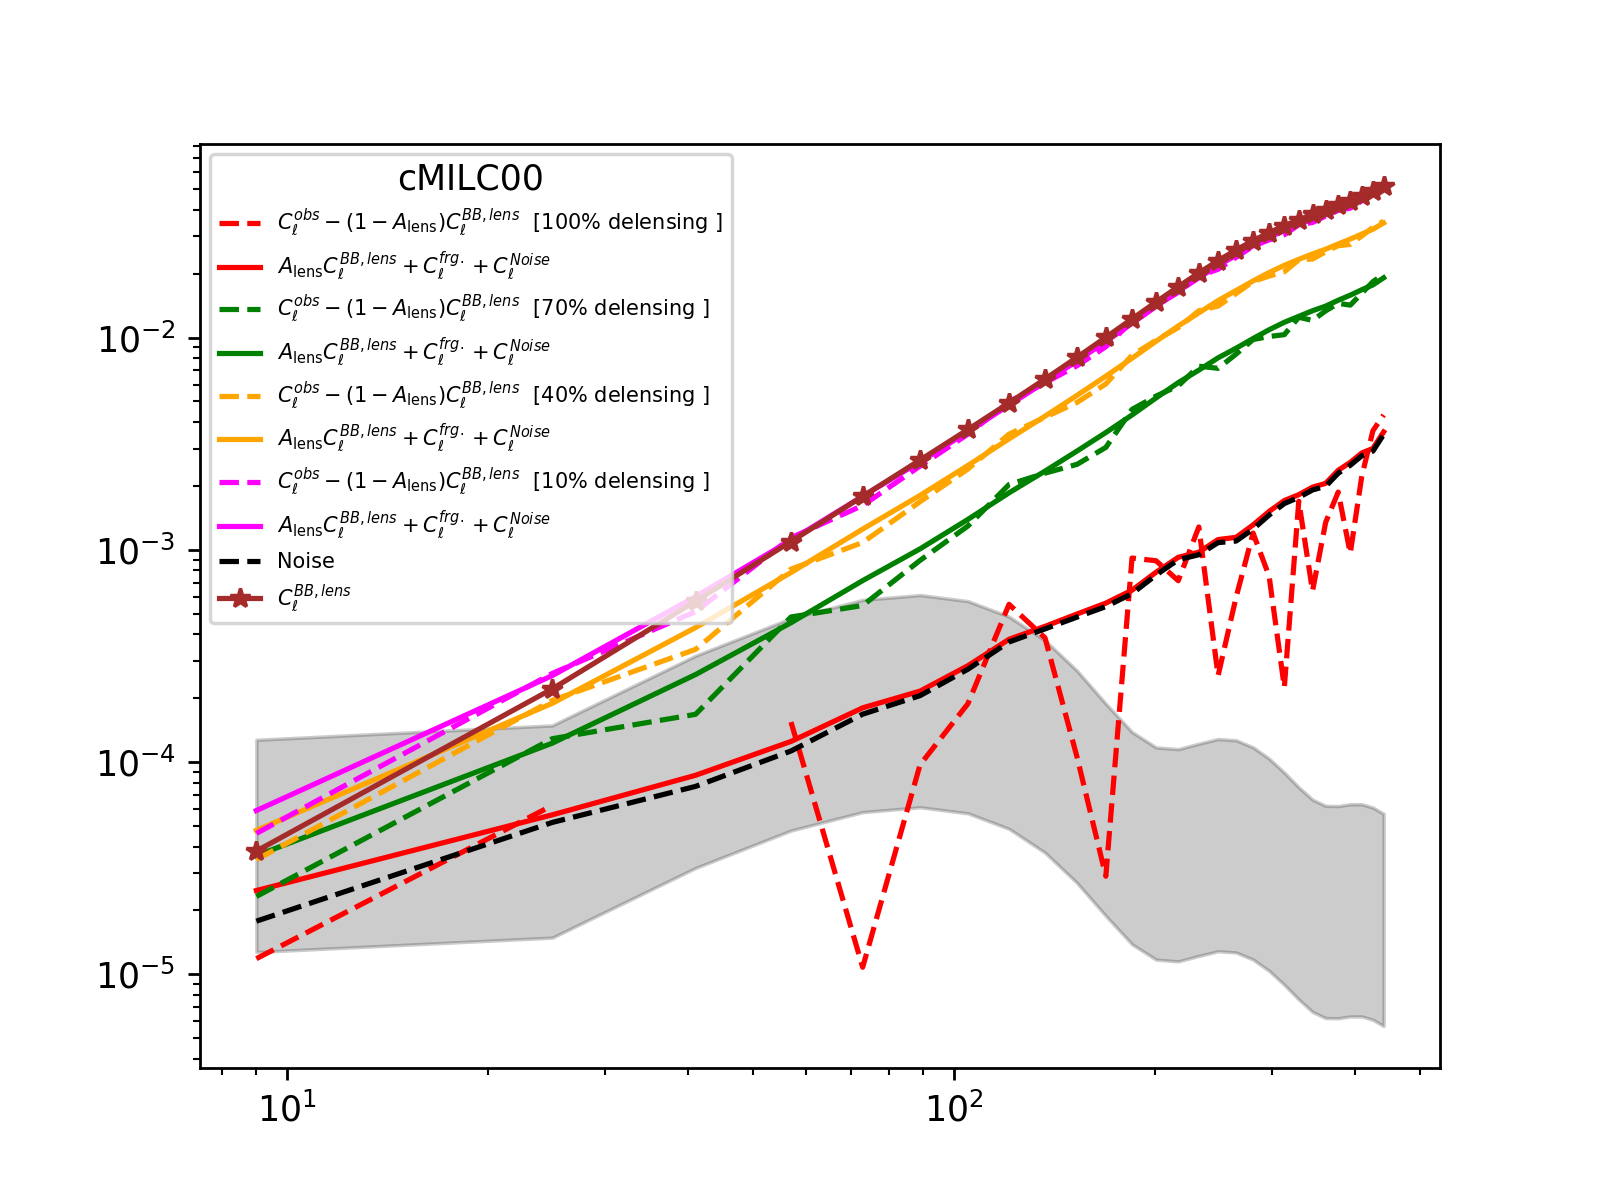

In [10]:
ion()
color={} 
color[rf.Alens_vals[0]]="red" 
color[rf.Alens_vals[1]]="green" 
color[rf.Alens_vals[2]]="orange"
color[rf.Alens_vals[3]]="magenta"

adr="cMILC00"

lbl0=r"$C_{\ell}^{obs} - (1- A_{\rm lens})C_{\ell}^{BB, lens}$"
lbl1=r"$A_{\rm lens} C_{\ell}^{BB, lens} + C_{\ell}^{frg.} + C_{\ell}^{Noise}$"
figure()
Alens=rf.Alens_vals[0]
plot(rf.lbin,rf.clbin["obs"][adr] - (1.-Alens)*rf.clbin["lens"],
     "--",c=color[Alens],label=lbl0 + "  [" + str(int(ceil((1-Alens)*100))) + r"% delensing ]")
plot(rf.lbin,Alens*rf.clbin["lens"] +rf.clbin["frg"][adr] + rf.clbin["noise"][adr],"-",c=color[Alens],label=lbl1)
Alens=rf.Alens_vals[1]
plot(rf.lbin,rf.clbin["obs"][adr] - (1.-Alens)*rf.clbin["lens"],
     "--",c=color[Alens],label=lbl0 + "  [" + str(int(ceil((1-Alens)*100))) + r"% delensing ]")
plot(rf.lbin,Alens*rf.clbin["lens"] +rf.clbin["frg"][adr] + rf.clbin["noise"][adr],"-",c=color[Alens],label=lbl1)
Alens=rf.Alens_vals[2]
plot(rf.lbin,rf.clbin["obs"][adr] - (1.-Alens)*rf.clbin["lens"],
     "--",c=color[Alens],label=lbl0 + "  [" + str(int(ceil((1-Alens)*100))) + r"% delensing ]")
plot(rf.lbin,Alens*rf.clbin["lens"] +rf.clbin["frg"][adr] + rf.clbin["noise"][adr],"-",c=color[Alens],label=lbl1)
Alens=rf.Alens_vals[3]
plot(rf.lbin,rf.clbin["obs"][adr] - (1.-Alens)*rf.clbin["lens"],
     "--",c=color[Alens],label=lbl0 + "  [" + str(int(ceil((1-Alens)*100))) + r"% delensing ]")
plot(rf.lbin,Alens*rf.clbin["lens"] +rf.clbin["frg"][adr] + rf.clbin["noise"][adr],"-",c=color[Alens],label=lbl1)
semilogy()
semilogx()
plot(rf.lbin,rf.clbin["noise"][adr],"k--",label="Noise")
plot(rf.lbin,rf.clbin["lens"],"-*",c="brown",label=r"$C_{\ell}^{BB, lens}$")
fill_between(rf.lbin,rf.clbin["bb"]*1e-2,rf.clbin["bb"]*1e-3,color="k",alpha=0.2)
legend(loc=0,title=adr,fontsize=6)
# loglog()
filename=fig_path + "ps_test_" + adr + ".pdf"
savefig(filename,bbox_inches="tight",dpi=250)

In [8]:
# import matplotlib.pyplot as plt
# ioff()
# for ia,Alens in enumerate(rf.Alens_vals):
#     filename=jpeg_path + "summary_statistics_" + str(ia).zfill(2) + ".jpeg"
#     fig, ax = subplots(nrows=1, ncols=3, figsize=(16, 4),sharey=True)
#     img0=ax[0].scatter(idx_list,sumstat["r_bias"][Alens],marker="*",s=100,label="Bias",c=sumstat["snr"][0.0],
#                 cmap=plt.cm.jet)
#     ax[0].legend(loc="upper left") ; ax[0].semilogy() ; ax[0].set_ylim(1e-4,2e-2)
#     ax[0].axhline(3e-3,linestyle="--",color="black",lw=2)
#     ax[0].axhline(5e-4,linestyle="-.",color="gray",lw=2)
#     ax[0].set_xticks(idx_list) ; ax[0].set_xticklabels(rf.adr_list,rotation=75,fontsize=8)
#     ax[0].grid(which="both",alpha=0.3)
#     ax[0].set_ylabel("Tensor to scalar ratio $r$",fontsize=15)

#     ax[1].scatter(idx_list,sumstat["r_err"][Alens],marker="*",s=100,label="Error",c=sumstat["snr"][0.0],
#                cmap=plt.cm.jet)
#     ax[1].legend(loc="upper left") ; ax[1].semilogy() ; ax[1].set_ylim(1e-4,2e-2)
#     ax[1].axhline(3e-3,linestyle="--",color="black",lw=2)
#     ax[1].axhline(5e-4,linestyle="-.",color="gray",lw=2)
#     ax[1].set_xticks(idx_list) ; ax[1].set_xticklabels(rf.adr_list,rotation=75,fontsize=8)
#     ax[1].grid(which="both",alpha=0.3)

#     ax[2].scatter(idx_list,sumstat["r_ul"][Alens],marker="*",s=100,label="95% Upper limit",c=sumstat["snr"][0.0],
#                cmap=plt.cm.jet)
#     ax[2].legend(loc="upper left") ; ax[2].semilogy() ; ax[2].set_ylim(1e-4,2e-2)
#     ax[2].axhline(3e-3,linestyle="--",color="black",lw=2)
#     ax[2].axhline(5e-4,linestyle="-.",color="gray",lw=2)
#     ax[2].set_xticks(idx_list) ; ax[2].set_xticklabels(rf.adr_list,rotation=75,fontsize=8)
#     ax[2].grid(which="both",alpha=0.3)
#     fig.colorbar(img0,ax=ax[2])
#     subplots_adjust(wspace=0.05, hspace=0)
#     fig.suptitle(r"$A_{\rm lens}=$" + str(Alens))
#     savefig(filename,bbox_inches="tight")
    
# cwd=os.getcwd()
# os.chdir(jpeg_path)
# cmd = "convert -delay 200 -loop 0 *.jpeg ../" +  rf.dd['simname']
# cmd = cmd + "_summary_statistics_lmax" + str(rf.lmax) + "_dl" + str(rf.dell) + ".gif"
# os.system(cmd)
# cmd="rm *.jpeg" ; os.system(cmd)
# os.chdir(cwd)

In [77]:
ion()
adr="cMILC10"
cmb=h.read_map(rf.dd["outdatapath"] + rf.dd["cmb_fname"],verbose=False)
fname=rf.dd["outdatapath"] + rf.dd["fnames"][adr]["cmb"]
obs=h.read_map(fname,verbose=False)
fname=rf.dd["outdatapath"] + rf.dd["fnames"][adr]["noise"]
noise=h.read_map(fname,verbose=False)
fname=rf.dd["outdatapath"] + rf.dd["fnames"][adr]["frg"]
frg=h.read_map(fname,verbose=False)

<IPython.core.display.Javascript object>


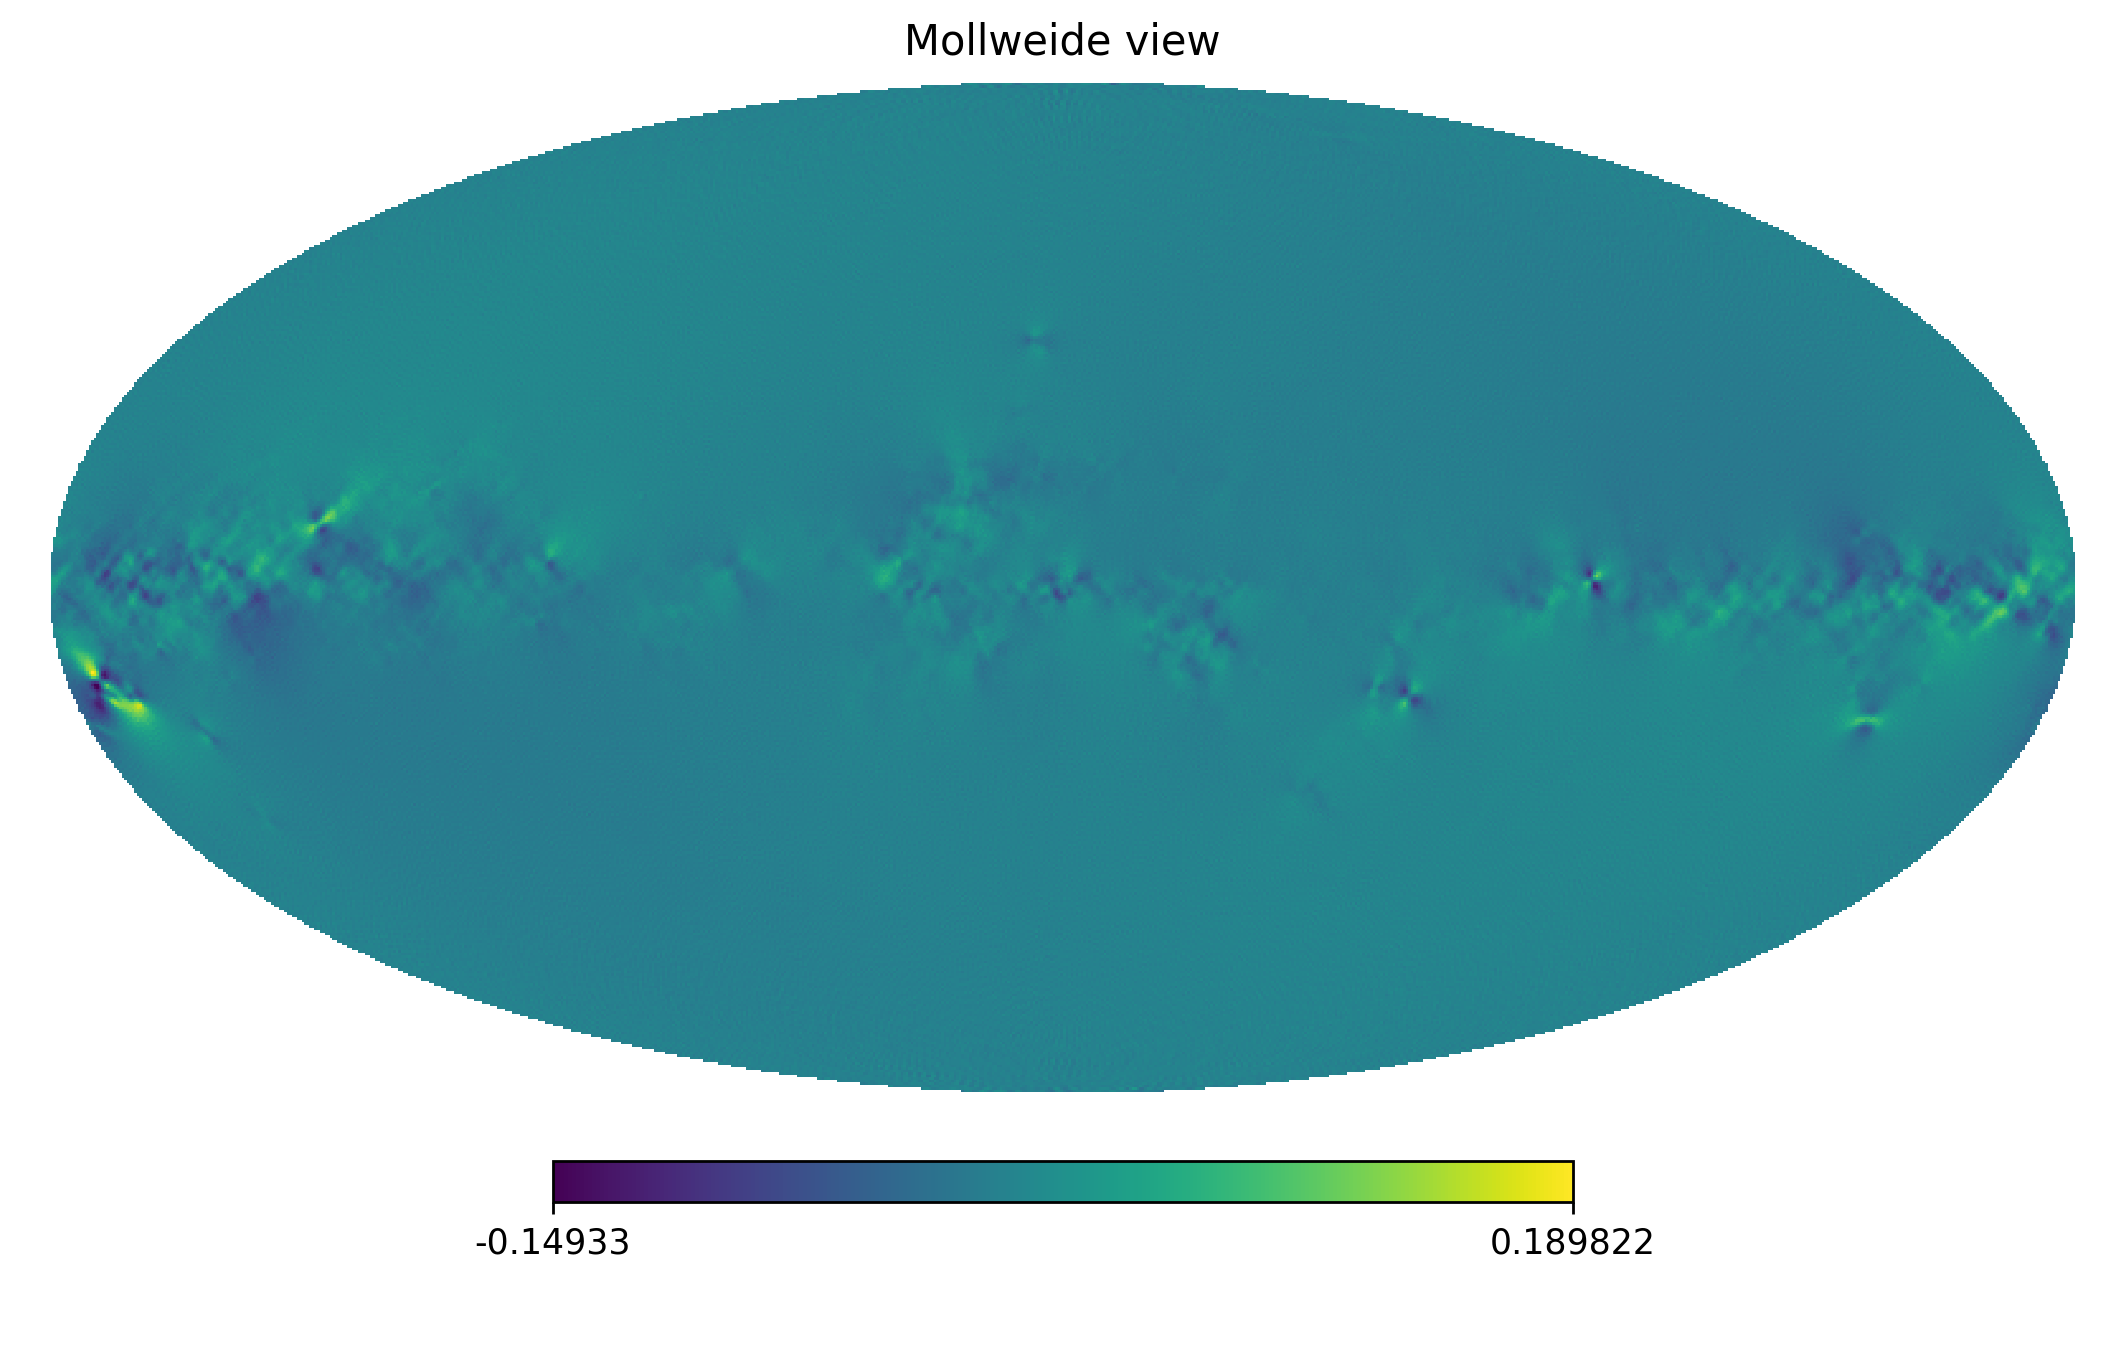

<IPython.core.display.Javascript object>


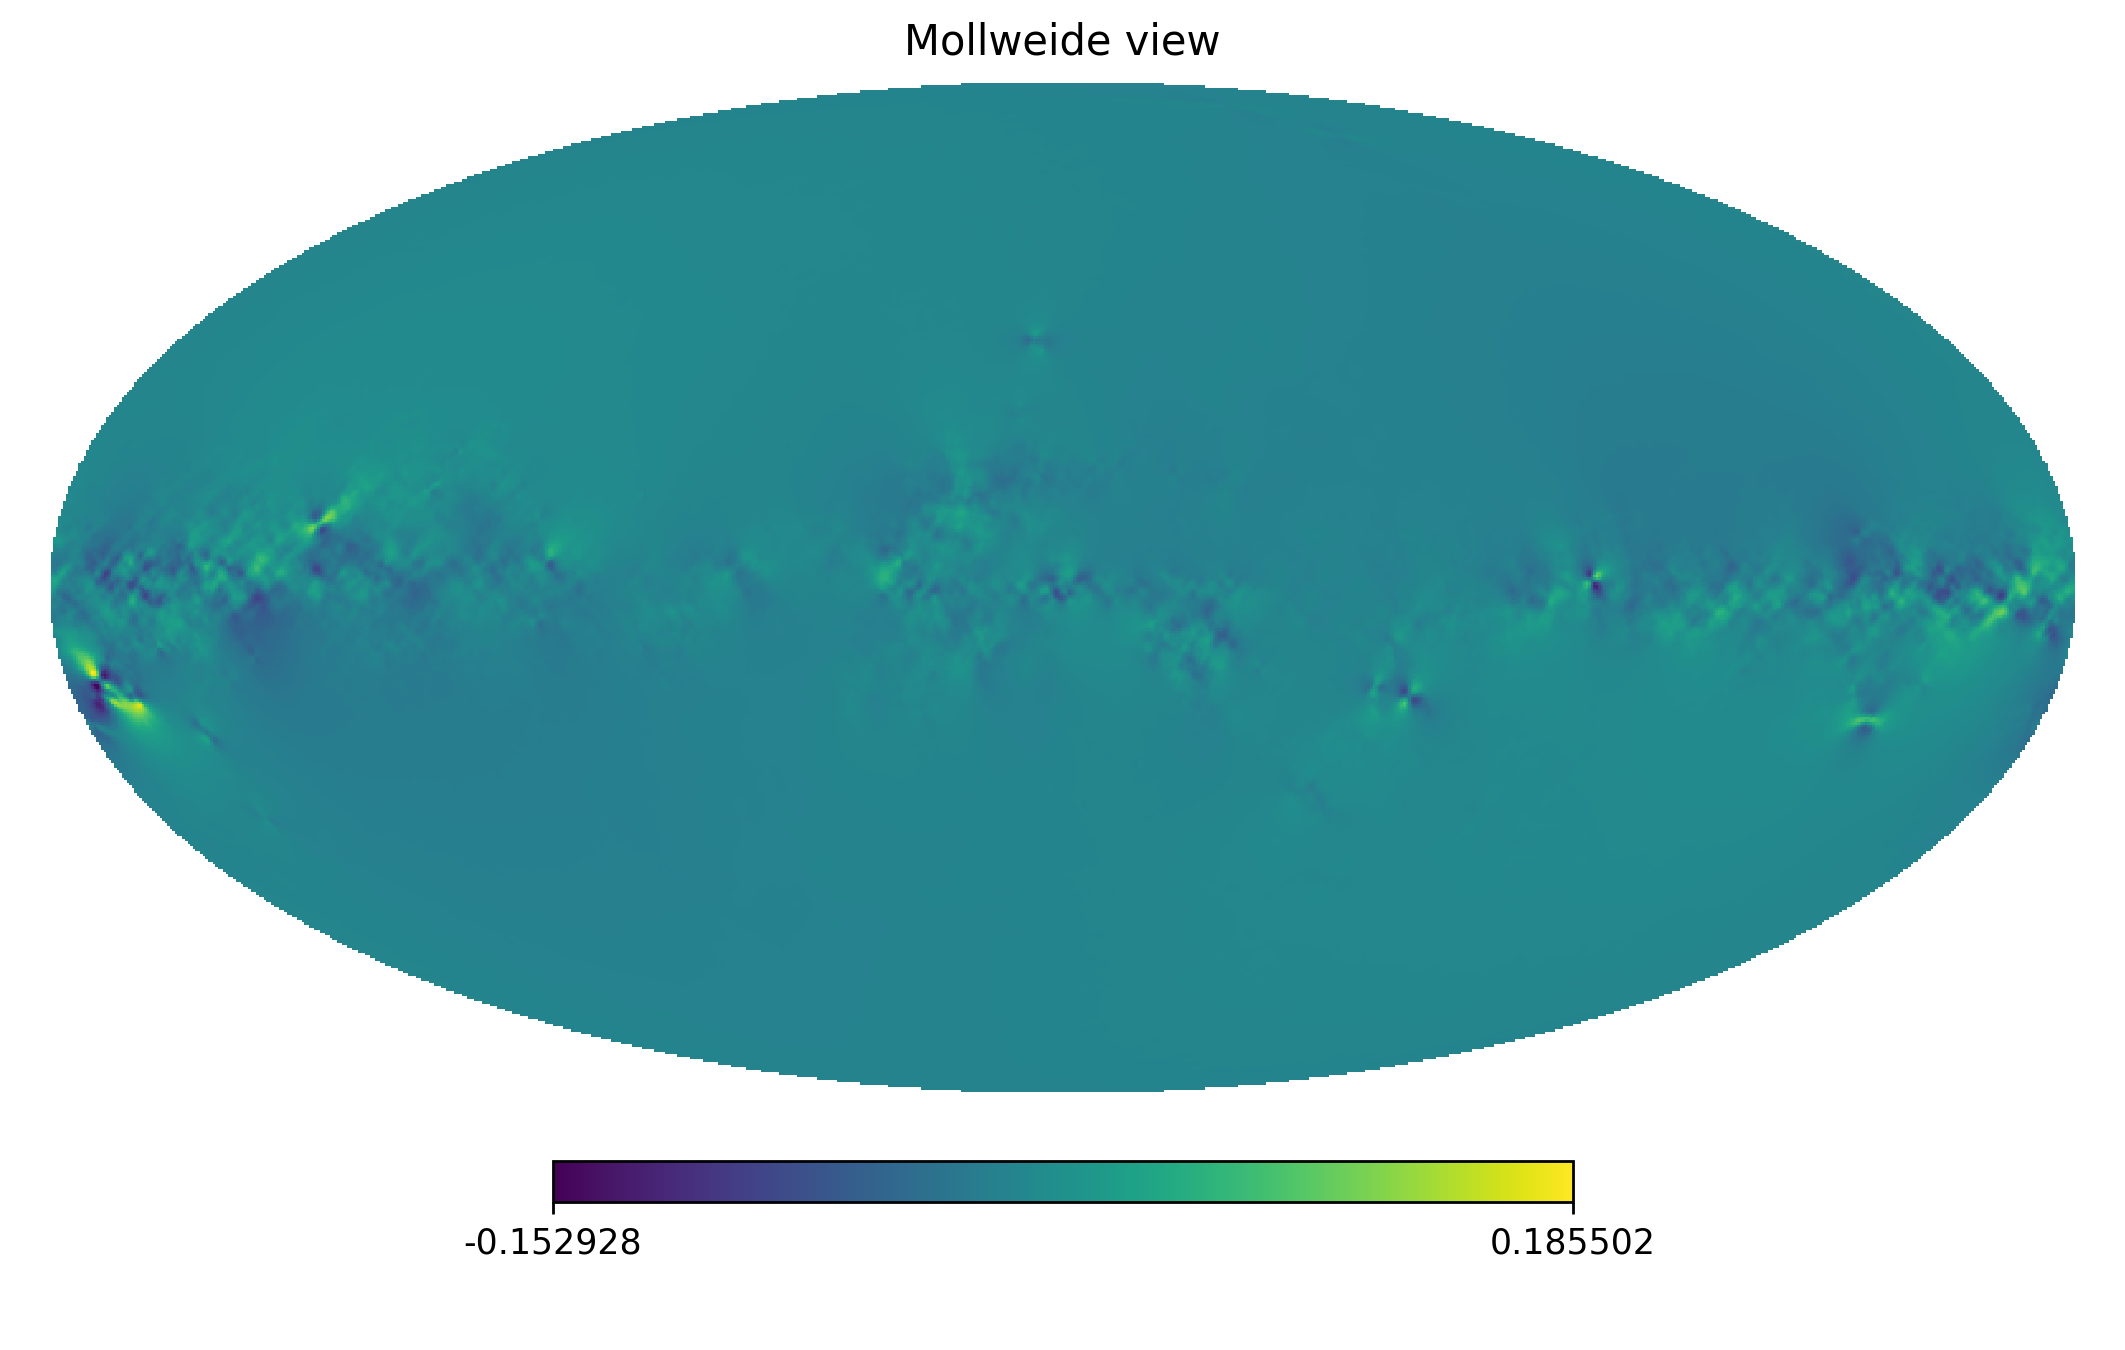

In [81]:
h.mollview(obs-cmb-noise)
h.mollview(frg)

<IPython.core.display.Javascript object>


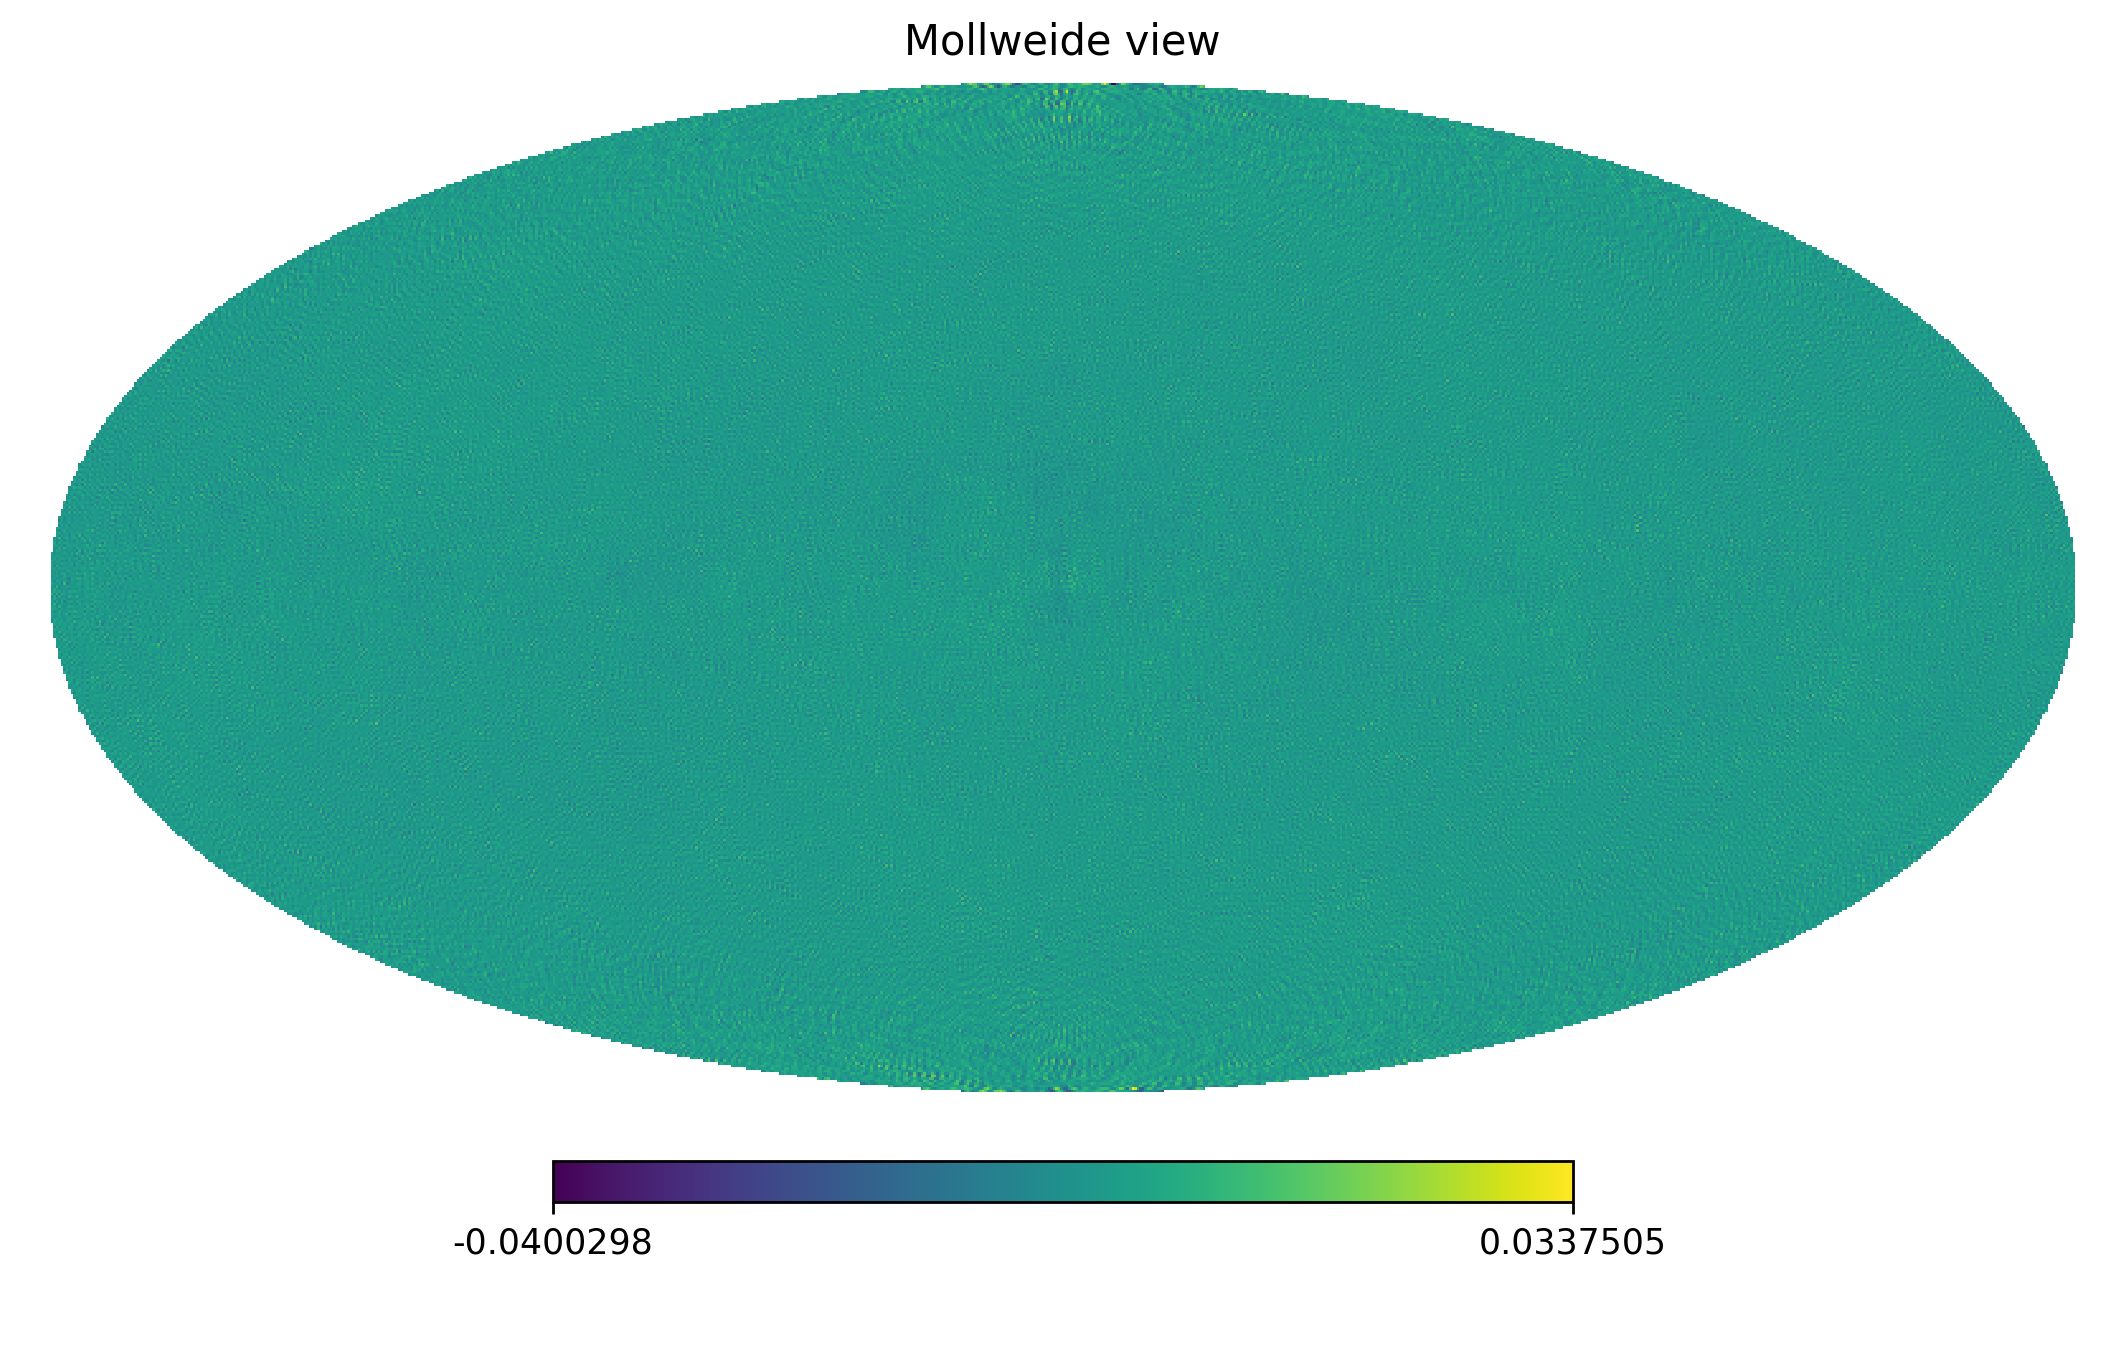

In [83]:
h.mollview((obs-cmb-noise-frg),rot=(0,0))
# h.orthview((obs-cmb-noise-frg)*mask,rot=(0,90))

<IPython.core.display.Javascript object>


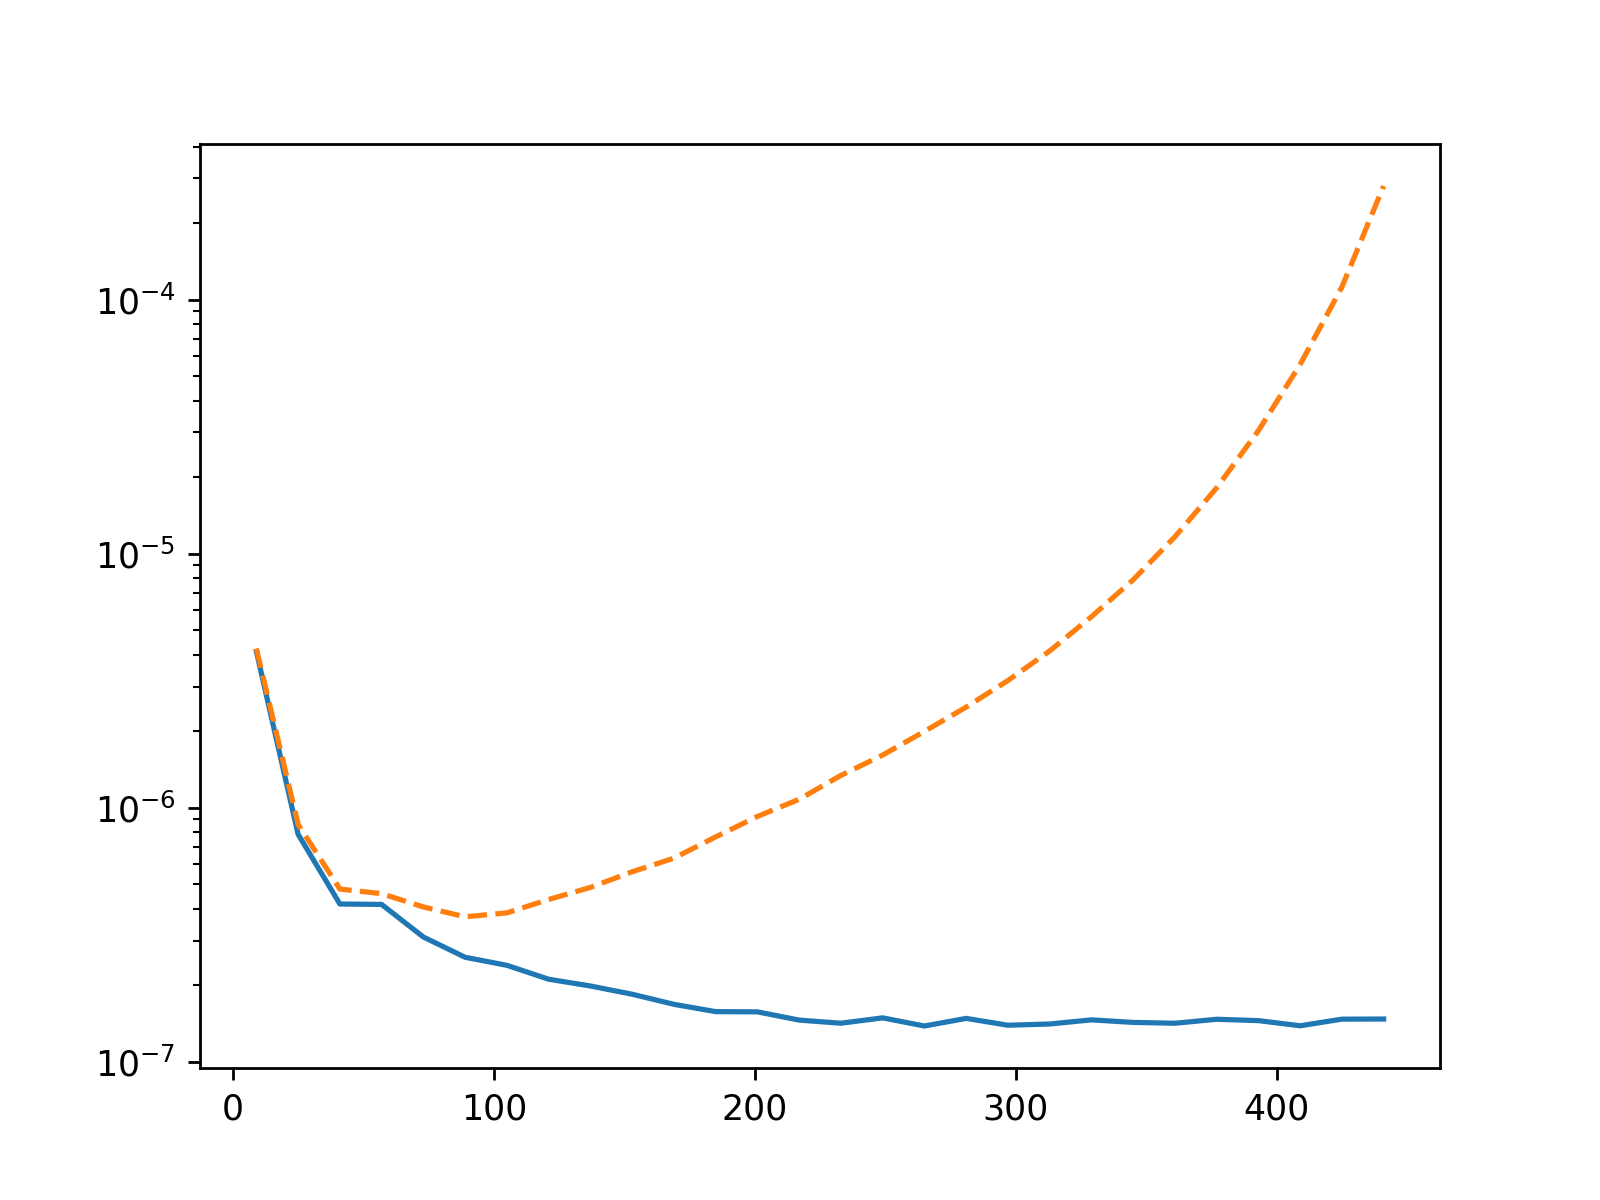

[]

In [79]:
ion()
figure()
plot(rf.lbin,rf.clbin["frg1"][adr])
plot(rf.lbin,rf.clbin["frg"][adr],"--")
semilogy()